<h3>Rui Benfeitas, Scilifelab, NBIS National Bioinformatics Infrastructure Sweden   </h3>
rui.benfeitas@scilifelab.se

**Abstract**  
In this notebook we will explore how to generate and analyse a multi-omic network comprising metabolites quantifications and gene expression. We will compare these networks against randomly generated networks, and compute different network metrics. At the end we will also perform a community analysis and functional characterization at the gene level.   
<br>
<br>
**Contents**
<div class="toc"><ul class="toc-item"><li><span><a href="#Biological-network-topology-analysis" data-toc-modified-id="Biological-network-topology-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Biological network topology analysis</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Association-analysis" data-toc-modified-id="Association-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Association analysis</a></span></li><li><span><a href="#Network-construction-and-preliminary-analysis" data-toc-modified-id="Network-construction-and-preliminary-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network construction and preliminary analysis</a></span></li><li><span><a href="#Centrality-analysis" data-toc-modified-id="Centrality-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Centrality analysis</a></span></li><li><span><a href="#Community-detection" data-toc-modified-id="Community-detection-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Community detection</a></span></li><li><span><a href="#Extracting-communities" data-toc-modified-id="Extracting-communities-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Extracting communities</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
## Preamble
import sklearn, itertools, random
import pandas as pd
import numpy as np
import igraph as ig
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests
import gseapy as gp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Biological network topology analysis

**Objective**  
In this notebook you will learn how to build and analyse a network built and analysed from a gene-metabolite association analysis. Other mixed networks may also be similarly analyzed, differring only in whether and how you can apply the final functional analysis.

**Data**  
As a test case we will be using the file [met_genes.tsv](met_genes.tsv) which contains abundances for 125 metabolites and 1992 genes, for 24 samples.

**Software**  
This notebook relies on python's igraph for most of the analyses. Most, if not all, functions used here can also be applied with R's igraph. Other packages exist for network analysis including [networkx](https://networkx.github.io/) and [graph-tool](https://graph-tool.skewed.de/). [Snap.py](https://snap.stanford.edu/snappy/) is also a good alternative for large networks.

We will build our network through an association analysis, but there are other methods to do this including [Graphical Lasso](http://statweb.stanford.edu/~tibs/ftp/graph.pdf) or [linear SVR](https://papers.nips.cc/paper/1187-support-vector-method-for-function-approximation-regression-estimation-and-signal-processing.pdf).

# Data preparation

You will use a gene expression dataset (RNAseq, expressed as TPM) from a disease group with 24 samples to keep analysis memory and time requirements reasonable for this lesson. It is assumed that all batch effects or other possible technical artifacts are not present, and that all data is ready for analysis. However, there are several important considerations in preprocessing your data:
 - How should you deal with missing values? Should you impute them? How?
 - Should you remove samples based on number of missing values?
 - How should you normalize your data in order to make it comparable throughout?
 
This will depend on the type of that that you have and what you want to do with it, and will severely affect downstream results. It is thus important to carefully think about this.

In [2]:
data=pd.read_csv('data/met_genes.tsv', sep="\t", index_col=0)
data.head()

Type       p10       p11       p12       p14       p15  \
feature                                                                         
C0_accarnitines         met  0.000000  0.000000  0.000000  0.000000  0.000000   
C2_accarnitines         met  0.007356  0.038454  0.011738  0.011923  0.015104   
C3_accarnitines         met  0.000000  0.000000  0.000000  0.000000  0.000888   
C3DC_C4OH_accarnitines  met  0.000000  0.000000  0.000455  0.001163  0.000000   
C5DC_C6OH_accarnitines  met  0.001035  0.001479  0.000430  0.001527  0.000485   

                             p16       p18       p22       p23  ...       p37  \
feature                                                         ...             
C0_accarnitines         0.000000  0.000000  0.000000  0.103152  ...  0.000000   
C2_accarnitines         0.012317  0.021905  0.017777  0.039760  ...  0.000000   
C3_accarnitines         0.001116  0.001682  0.001024  0.002179  ...  0.000000   
C3DC_C4OH_accarnitines  0.000000  0.000000  0.000000  0.001065  ...  0.000000   
C5DC_C6OH_accarnitines  0.000792  0.000954  0.000995  0.001356  ...  0.005792   

                             p38        p4       p40       p41       p46  \
feature                                                                    
C0_accarnitines         0.000000  0.000000  0.000000  0.000000  0.000000   
C2_accarnitines         0.012542  0.018896  0.020212  0.015263  0.012510   
C3_accarnitines         0.000827  0.000000  0.000000  0.000000  0.000000   
C3DC_C4OH_accarnitines  0.000480  0.000000  0.000717  0.000000  0.000782   
C5DC_C6OH_accarnitines  0.000400  0.000987  0.001255  0.000885  0.001710   

                             p48        p5        p8        p9  
feature                                                         
C0_accarnitines         0.000000  0.000000  0.000000  0.049757  
C2_accarnitines         0.009677  0.015757  0.010706  0.018615  
C3_accarnitines         0.000000  0.000000  0.000000  0.000995  
C3DC_C4OH_accarnitines  0.000398  0.000000  0.000000  0.000312  
C5DC_C6OH_accarnitines  0.000597  0.001218  0.000848  0.000507  

[5 rows x 25 columns]

No duplicated features are present.

In [3]:
any(data.index.duplicated()) 

False

In [4]:
data.groupby('Type').agg('count')[['p10']] #1992 genes, 125 metabolites

p10
Type       
genes  1992
met     125

In [5]:
data.shape #2117 features, 25 samples

(2117, 25)

A very quick view shows that several gene clusters are found, including two major groups. However, the analysis below does not perform any statistical filtering.

# Association analysis

Our initial network analysis will be performed on the association analysis using Spearman correlations. Because this network has a big chance of producing false positives we will consider [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to control for familywise error, as well as [FDR](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure).  

A very quick view shows that several gene clusters are found, including two major groups. However, the analysis below does not perform any statistical filtering.

In [6]:
values=data.loc[:,data.columns!='Type']
meta=data[['Type']]

In [7]:
values.isna().any().any() #we have no rows with NA

False

We will perform a gene-gene, gene-metabolite, and metabolite-metabolite association analysis by computing pairwise [Spearman correlations](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr). Choosing other non-parametric (Kendall or Spearman) vs parametric (Pearson) methods depends on your data. Here, because we have a small sample size, and want to save on computational time we choose Spearman. 

The following takes a few minutes to run.

In [8]:
#Correlation and P val matrices
Rmatrix, Pmatrix= sp.stats.spearmanr(values.T)
Rmatrix=pd.DataFrame(Rmatrix, index=values.index.copy(), columns=values.index.copy())

#resulting R matrix
sns.clustermap(Rmatrix, cmap="RdBu_r", center=0); 

If we look at the matrix of P values, we can already see that many of the correlations in the top right columns are not significant even before multiple hypothesis correction:

In [9]:
Pmatrix=pd.DataFrame(Pmatrix, index=values.index.copy(), columns=values.index.copy())
changed_Pmatrix=Pmatrix.copy()
changed_Pmatrix[changed_Pmatrix>0.01]=1
#resulting P matrix, similar to that seen in the section above
sns.clustermap(changed_Pmatrix); 

We will now adjust the P values based on the number of comparisons done. The heatmaps above are highlighting a total of $2117^2 \approx 4.5m$ correlations. However, these numbers consider that the same correlation is computed twice (gene A vs gene B, and gene B vs gene A). If we were to include all correlations, we would thus be including many repeated analyses, and we are only interested in half of that above, and excluding the correlation of a feature with itself.   
This means $\frac{2117!}{2!(2117-2)!} \approx 2.2m$ correlations. At an error rate of 0.05, this means that the probability of finding at least one false positive is nearly 100%: $1-0.95^{2000000} \approx 1$. We thus need to correct P values.

In the following cell, we convert the matrix of p*p features to a long matrix, concatenate both R and P for each correlation, and correct based on [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction) (`Padj`) and [FDR](https://en.wikipedia.org/wiki/False_discovery_rate) (Benjamin-Hochberg).

In [11]:
#prepare P matrix
Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(bool))
Psquared.columns.name='Feat2'
Pmatrix=Pmatrix.stack()
Pmatrix.index.names=['v1','v2']
Pmatrix=Pmatrix.reset_index()
Pmatrix.columns=['feat1','feat2','P']

In [12]:
#prepare R matrix
Rmatrix=Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(bool))
Rmatrix.columns.name='Feat2'
Rmatrix=Rmatrix.stack()
Rmatrix.index.names=['v1','v2'] #Avoid stacked names colliding
Rmatrix=Rmatrix.reset_index()
Rmatrix.columns=['feat1','feat2','R']

In [13]:
# join both
PRmatrix=pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['feat1','feat2']) #Correlation matrix with both R and P
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2].dropna()

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [14]:
#Multiple hypothesis correction computed on the P column
adjP=pd.DataFrame(multipletests(PRmatrix['P'], method='bonferroni', alpha=0.01)[1], columns=['Padj'])
FDR=pd.DataFrame(multipletests(PRmatrix['P'], method='fdr_bh', alpha=0.01)[1], columns=['FDR'])

PRmatrix=pd.concat([ PRmatrix, adjP], axis=1)
PRmatrix=pd.concat([ PRmatrix, FDR], axis=1)

PRmatrix.head()

/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/2364494596.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(np.bool))
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/2364494596.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmatrix=Rmatrix.where

feat1                   feat2         R         P  Padj       FDR
0  C0_accarnitines         C2_accarnitines  0.375326  0.070718   1.0  0.149290
1  C0_accarnitines         C3_accarnitines  0.519174  0.009329   1.0  0.033441
2  C0_accarnitines  C3DC_C4OH_accarnitines  0.395363  0.055848   1.0  0.125357
3  C0_accarnitines  C5DC_C6OH_accarnitines -0.029917  0.889631   1.0  0.928289
4  C0_accarnitines      C5MDC_accarnitines -0.137801  0.520795   1.0  0.643703

In [15]:
#total number of correlations w/o repetition: 2.2m
PRmatrix.shape[0]

2239786

Considering the Bonferroni correction we find 16305 correlations that are statistically significant at an $\alpha < 0.01$. If we consider instead FDR as correction method, we find 402368, which at a FDR of 0.01 implies $0.01 \times 402368 = 4023$ false positives.

In [16]:
sum(PRmatrix.Padj<0.01)

16305

In [17]:
sum(PRmatrix.FDR<0.01)

402368

Let's add two additional columns, where we assign `R=0` for those correlations that are not statistically significant (`adjP > 0.01`, and `FDR > 0.01`). 

In [18]:
PRmatrix.loc[:,'R (padj)']=PRmatrix['R'].copy()
PRmatrix.loc[:,'R (fdr)']=PRmatrix['R'].copy()
PRmatrix.loc[PRmatrix['Padj']>0.01,'R (padj)']=0
PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0

all_mets=meta.loc[meta.Type=='met'].index
PRmatrix['feat1_type']=['met' if x in all_mets else 'gene' for x in PRmatrix.feat1 ]
PRmatrix['feat2_type']=['met' if x in all_mets else 'gene' for x in PRmatrix.feat2 ]
PRmatrix['int_type']=PRmatrix.feat1_type+'_'+PRmatrix.feat2_type
PRmatrix.to_csv('data/association_matrix.tsv', sep="\t", index=False) #export correlation matrix for faster loading

Now we can see how the initial heatmap of correlations looks. The next cell converts the matrix from long to squared matrix so that we can generate the heatmap. We will plot those features that show statistically significant associations with more than 5% of the features after FDR correction, and compare them between FDR- and Bonferroni-corrected datasets. 

The following plot shows the heatmap of the Spearman rank correlation coefficients after Bonferroni-correction - correlations where Padj > 0.05 are shown as 0.

In [19]:
#Transforming to a squared matrix again
PRQ=pd.concat([
    PRmatrix.copy(), 
    PRmatrix.copy().rename(columns={'feat1':'feat2','feat2':'feat1'}).loc[:,PRmatrix.columns]
         ]).drop_duplicates()

Rmatrix_fdr=PRQ.copy().pivot(index='feat1',columns='feat2',values='R (fdr)')
Rmatrix_fdr=Rmatrix_fdr.loc[Rmatrix_fdr.sum()!=0]
Rmatrix_padj=PRQ.copy().pivot(index='feat1',columns='feat2',values='R (padj)')

Rmatrix_fdr=Rmatrix_fdr.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)
Rmatrix_padj=Rmatrix_padj.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)


#Showing only the top correlated features
top_features=Rmatrix_fdr.index[(Rmatrix_fdr!=0).sum()>0.05*Rmatrix_fdr.shape[0]] #top features based on FDR
Rmatrix_fdr_top=Rmatrix_fdr.copy().loc[top_features,top_features] #subsetting R (fdr corrected) matrix
Rmatrix_padj_top=Rmatrix_padj.copy().loc[top_features,top_features] #subsetting R (bonferroni corrected) matrix

g=sns.clustermap(Rmatrix_padj_top, cmap="RdBu_r", center=0);
g.fig.suptitle('Spearman R (Padj < 0.01, Bonferroni)');
plt.show()

/Users/cob-aaf/Documents/Projects/r_python/my_env/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


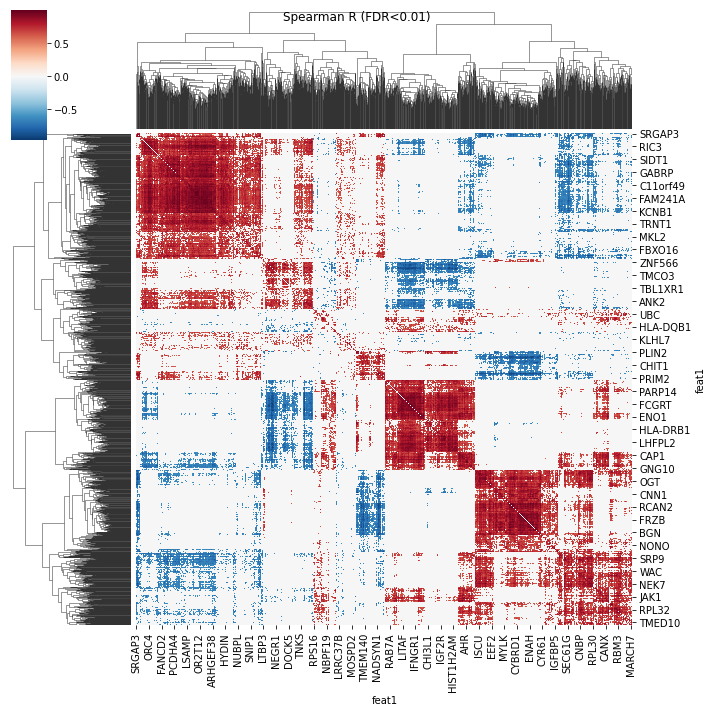

In [20]:
g=sns.clustermap(Rmatrix_fdr_top, cmap="RdBu_r", center=0);
g.fig.suptitle('Spearman R (FDR<0.01)');
plt.show()

The plots above show that the Bonferroni correction is only selecting very high (absolute) correlations. This should remove false positives, but it may also remove weaker correlations that are biologically relevant and true positives. The Bonferroni correction also removes most of the negatively-associated features. Notice this from the distribution of correlation coefficients:

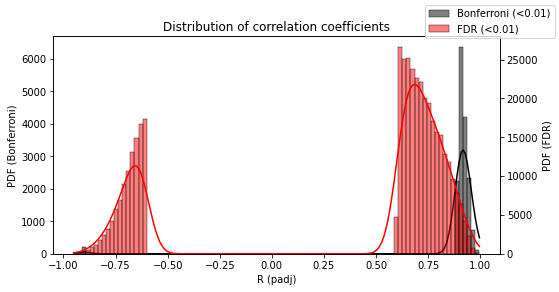

In [21]:
shortPR=PRmatrix.copy().loc[:,['feat1','feat2','R (padj)','R (fdr)']]
shortPR=shortPR.loc[shortPR.feat1!=shortPR.feat2]

fig=plt.figure(figsize=(8,4))
p=sns.histplot(shortPR['R (padj)'][shortPR['R (padj)']!=0], color='black', label='Bonferroni (<0.01)', kde=True, bins=100);
p.set(ylabel='PDF (Bonferroni)')
ax2=p.twinx()
g=sns.histplot(shortPR['R (fdr)'][shortPR['R (fdr)']!=0], ax=ax2, color='red', label='FDR (<0.01)', kde=True, bins=100);
g.set(ylabel='PDF (FDR)')

fig.legend()
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
plt.show()

We can also observe that the Bonferroni correction yields a more homogeneous number of associated features for each feature (i.e. first neighbors), compared to the FDR filtering. This has a consequence on the network structure.

/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/2296206468.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  neighbor_number=pd.concat([neighbor_number, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/2296206468.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  neighbor_number=pd.concat([neighbor_number, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/2296206468.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  neighbor_number=pd.concat([neighbor_number, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/2296206468.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  neighbor_number=pd.conca

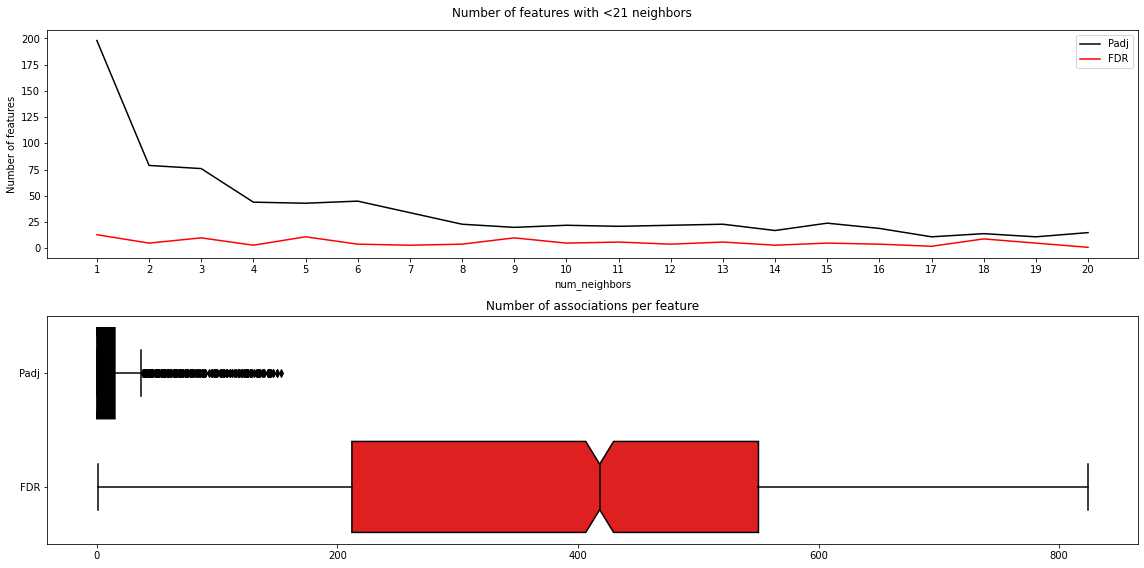

In [22]:
neighbor_number=pd.DataFrame()
for n_neighbors in np.arange(1,21):
    padj_count=((Rmatrix_padj!=0).sum()==n_neighbors).sum()
    fdr_count=((Rmatrix_fdr!=0).sum()==n_neighbors).sum()
    
    out=pd.Series([padj_count, fdr_count], index=['num_features(Padj)','num_features(FDR)'], name=n_neighbors)
    neighbor_number=pd.concat([neighbor_number, out],1)
    
neighbor_number=neighbor_number.T.rename_axis('num_neighbors').reset_index()

fig,ax=plt.subplots(figsize=(16, 8), nrows=2)
ax=ax.flatten()
sns.lineplot(data=neighbor_number, x='num_neighbors', y='num_features(Padj)', color='black', label='Padj', ax=ax[0]);
sns.lineplot(data=neighbor_number, x='num_neighbors', y='num_features(FDR)', color='red', label='FDR', ax=ax[0]);
ax[0].set(ylabel='Number of features')
fig.suptitle('Number of features with <21 neighbors')
ax[0].set_xticks(np.arange(1,21,1));

### boxplot requires a long df
feat_associations_padj=pd.concat([
    shortPR.copy().loc[shortPR['R (padj)']!=0,][['feat1','feat2']],
    shortPR.copy().loc[shortPR['R (padj)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

feat_associations_fdr=pd.concat([
    shortPR.copy().loc[shortPR['R (fdr)']!=0,][['feat1','feat2']],
    shortPR.copy().loc[shortPR['R (fdr)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

feat_associations=pd.concat([feat_associations_padj, feat_associations_fdr],1, sort=True)
feat_associations.fillna(0,inplace=True)
feat_associations.columns=['Padj','FDR']

sns.boxplot( data=feat_associations, notch=True, ax=ax[1], orient='h', palette={'Padj':'black','FDR':'red'});
plt.title('Number of associations per feature')
fig.tight_layout()
plt.show()

Note that the Bonferroni correction leads to many nodes being associated with 1 or 2 other nodes, whereas the FDR correction leads to substantially higher number of associations for some of the nodes. This can also raise questions about the biological plausibility of such high number of associations - is it biologically significant that a gene is co-expressed with 800 other genes/metabolites?

We can also be a bit more strict on the FDR that we consider as statistically significant. Let's compare the number of potential false positives at different FDR. The following plot further highlights an FDR = 0.01 (dashed gray line).

/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/3215240286.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  fdr_df=pd.concat([fdr_df, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/3215240286.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  fdr_df=pd.concat([fdr_df, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/3215240286.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  fdr_df=pd.concat([fdr_df, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000gn/T/ipykernel_6950/3215240286.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  fdr_df=pd.concat([fdr_df, out],1)
/var/folders/58/7hh3m65j5yl2yz26w2njdk600000

ValueError: cannot reindex on an axis with duplicate labels

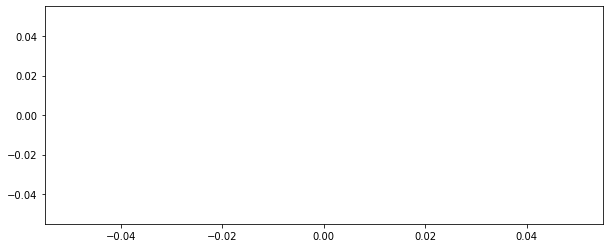

In [24]:
fdr_df=pd.DataFrame()
for fdr in np.append(np.geomspace(1e-4, 0.01, 30), [0.02, 0.03, 0.04, 0.05,0.1]):
    out=pd.Series([fdr,(PRmatrix.Padj<fdr).sum(),np.round(fdr*((PRmatrix.Padj<fdr).sum()),2)],
                  index=['FDR','num_edges','num_fp'])
    fdr_df=pd.concat([fdr_df, out],1)
fdr_df=fdr_df.T
    
fig,ax=plt.subplots(figsize=(10,4))
sns.lineplot(data=fdr_df, x='FDR', y='num_edges', color='black', ax=ax, label='Edge number')
sns.lineplot(data=fdr_df, x='FDR', y='num_fp', color='red', ax=ax, label='# potential false positives')
ax.set(xscale='log', yscale='log', ylabel='Edge #');
ax.set_xticks([1e-4,1e-3, 1e-2, 1e-1, 0.05])
ax.set_xticklabels([1e-4,1e-3, 1e-2, 1e-1, 0.05])
ax.axvline(0.01, dashes=[0,0,5,5], color='gray');

Note how the number of potential false positives increases substantially with the number of edges, showing that networks with large sizes can have a high number of false positives. Thus, selecting an appropriate cut-off needs to take into account these two quantities.  
By being more conservative, one will be more sure of the identified associations but a network that is too small may miss biologically important associations (i.e. have many false negatives) and become too sparse to be representative of the biology. This may result in very small communities of nodes, and many dyads and isolated vertices. On the other hand, a network that is too big may display a very high number of associations that are not observed biologically (false positives). It is likely that such networks will display large communities and high density. Think of the balance between [Type I and Type II errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors#Type_I_error). Unfortunately, because this is an unsupervised problem we have no way to compute the false negative rate. This is not always the case: if you are dealing with human proteomics, one possible solution to identify false negatives can be from using a [reference map of human protein-protein interactions](https://www.nature.com/articles/s41586-020-2188-x).

In choosing an appropriate cut-off we will thus rely on the number of potential false positives and the network dimensions. In another section below, we will compare different networks and explore how their structure differs both in network properties (e.g. [centrality](https://en.wikipedia.org/wiki/Centrality)) and [communities](https://en.wikipedia.org/wiki/Community_structure). Bear in mind that false positives should not have an extensive impact on the network communities if these spurious associations are randomly distributed throughout the network, since the community interrogation algorithms usually compute regions of high density. 

We will also look at how the statistically significant correlation coefficients change FDR.

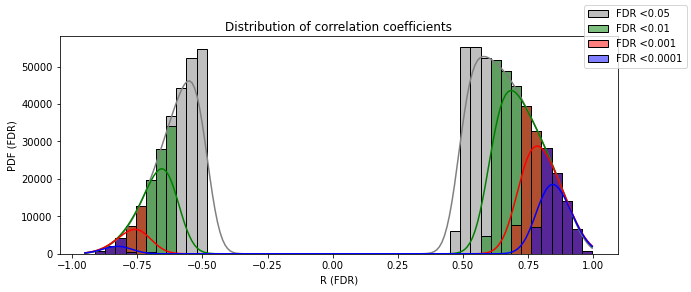

In [25]:
fig,ax=plt.subplots(figsize=(10,4))

for fdr in [0.05, 0.01, 0.001, 0.0001]:
    ## Plotting R distribution
    temp=PRmatrix.copy()
    temp.loc[:,'R (fdr)']=temp['R'].copy()
    temp.loc[temp['FDR']>fdr,'R (fdr)']=0
    
    temp=temp.loc[temp.feat1!=shortPR.feat2]
    
    color={0.05:'gray',0.01:'green',0.001:'red',0.0001:'blue'}[fdr]

    
    p=sns.histplot(
        temp['R (fdr)'][temp['R (fdr)']!=0], color=color, label='FDR <'+str(fdr), kde=True, ax=ax, bins=50);
    p.set(ylabel='PDF (FDR)')

fig.legend()
plt.xlabel('R (FDR)');
plt.title('Distribution of correlation coefficients');

Predicably, by being more conservative we will be selecting higher absolute correlation coefficients. In this test case we are considering only 25 samples. Larger sample sizes lead to lower nominal and adjusted p-values, and a higher number of statistically significant but milder correlation coefficients. In such cases, one may be more conservative in the significance threshold. Henceforth, we will consider as statistically significant those edges where FDR < 0.01.

One last point comes from the comparison of statistically significant associations within and between omics. Note how so few inter-omic associations are identified, and that Bonferroni correction completely misses any.

In [26]:
bonferroni_significant=PRmatrix.copy().loc[PRmatrix.Padj<0.01].loc[:,['feat1','feat2','R','int_type']]
bonferroni_significant['sig_test']='bonferroni'
fdr_significant=PRmatrix.copy().loc[PRmatrix.FDR<0.01].loc[:,['feat1','feat2','R','int_type']]
fdr_significant['sig_test']='FDR'

pd.concat([bonferroni_significant,fdr_significant]).groupby(['sig_test','int_type'])['R'].agg('count').reset_index()

sig_test   int_type       R
0         FDR  gene_gene  398274
1         FDR   met_gene     118
2         FDR    met_met    3976
3  bonferroni  gene_gene   15434
4  bonferroni    met_met     871

### Questions

In building a graph from an association analysis:
- Why do you think that most significant correlations are found only within each omic? 
- How will you deal with the positive and negative sets of correlations above?
- Will you consider the network as weighted? Directed?
- Which dataset would you select for further analysis: the Bonferroni or the FDR-corrected? Why?
- What preliminary tests would you perform on the graph to assess whether node relationships are random?

# Network construction and preliminary analysis

We will now build 4 different networks to analyse further:
- A full association network filtered using FDR-corrected P values (<0.01). This is an unweighted network.
- The subset of positively associated features, where correlation coefficient is used as weight.
- kNN-G that we will generate from the expression profile. This will be unweighted.
- A random network based on the [Erdos-Renyi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), with the same node and edge number of each network. 

This will be a null-model for our analyses. The idea is that if a certain property found in one of our graphs is  reproduced in a random graph, then we do not need to account for any other possible explanations for that feature. In other words, if a property of a graph (e.g. clustering) is not found in a random network, we can assume that it does not appear in our biological network due to randomness.

In [27]:
# Prepares table for being read by igraph
PRmatrix=pd.read_csv('data/association_matrix.tsv', sep="\t")
PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0
PRmatrix=PRmatrix.loc[PRmatrix['R (fdr)']!=0,['feat1','feat2','R (fdr)']]
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2] #drops self correlations

fdr_pos_mat=PRmatrix.loc[PRmatrix['R (fdr)']>0]
fdr_neg_mat=PRmatrix.loc[PRmatrix['R (fdr)']<0]

PRmatrix=PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,] #selects only nodes also found in the positive network so that we can compare networks of the same sizes

We will now build the kNNG, using distances as input to determine the nearest neighbours. Because this data contains both gene expressions and metabolite quantifications, we need to normalize them beforehand. (We didn't need to do this above as we were comparing ranks)

We start by standardizing all features

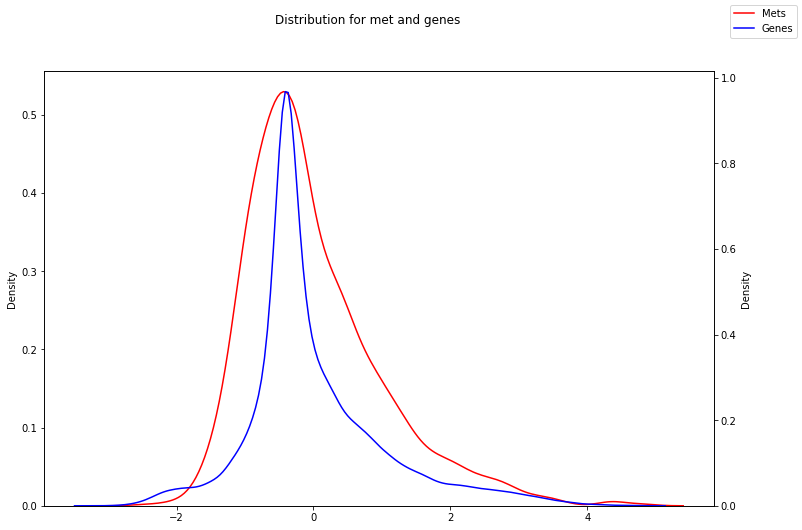

In [28]:
#Imports and normalizes met and gene data so that we can compute similarities between them
from sklearn.preprocessing import StandardScaler
data=pd.read_csv('data/met_genes.tsv', sep="\t", index_col=0)

scaled_data=pd.DataFrame(StandardScaler().fit_transform(data.loc[:,data.columns!='Type'].T).T, columns=data.columns[data.columns!='Type'], index=data.index)
scaled_data_values=scaled_data.copy()
scaled_data['Type']=data.Type

#Plots the data distribution
fig,ax=plt.subplots(figsize=(12,8))
sns.kdeplot(
    scaled_data.loc[scaled_data.Type=='met',scaled_data.columns!='Type'].values.flatten(), 
    color='r', label='Mets', ax=ax, legend=False)
ax2=ax.twinx()
sns.kdeplot(
    scaled_data.loc[scaled_data.Type=='genes',scaled_data.columns!='Type'].values.flatten(),
    color='b', label='Genes', ax=ax2, legend=False)
fig.suptitle('Distribution for met and genes');
fig.legend();

We will now generate the graphs from the dataframes above

In [29]:
### Generating the kNN graph
#Computes a kNN adjacency matrix from the input dataset
#and prepares table for being read by igraph
input_ds=scaled_data_values.loc[scaled_data_values.index.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten()))]
knnG=sklearn.neighbors.kneighbors_graph(input_ds.values, 200, metric='euclidean')
knnG=pd.DataFrame(knnG.toarray(), columns=input_ds.index.copy(), index=input_ds.index.copy())  #adjacency matrix
knnG.index.name='gene1'
knnG.columns.name='gene2'
knnG=knnG.stack().reset_index().rename(columns={0:'Connectivity'})
knnG=knnG.loc[knnG['Connectivity']!=0]

### Generates each of the graphs
#positive associations, weighted
pos_w=ig.Graph.TupleList([tuple(x) for x in fdr_pos_mat.values], directed=False, edge_attrs=['w'])

#full network, unweighted
edge_list=PRmatrix.copy().loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,['feat1','feat2']].values
all_u=ig.Graph.TupleList([tuple(x) for x in edge_list], directed=False)

#knnG, unweighted
knn=ig.Graph.TupleList([tuple(x) for x in knnG.values], directed=False)

#random network, unweighted, node and edge number based on a network of the same size
random_posw=ig.Graph.Erdos_Renyi(n=input_ds.shape[0], m=len(fdr_pos_mat.values), directed=False, loops=False)

random_allu=ig.Graph.Erdos_Renyi(n=input_ds.shape[0], m=len(edge_list), directed=False, loops=False)

random_knn=ig.Graph.Erdos_Renyi(n=input_ds.shape[0], m=len(knnG.values), directed=False, loops=False)

For representation purposes we will see how a short knn graph looks - be careful in drawing the others, as they have many more edges it becomes computationally heavy.

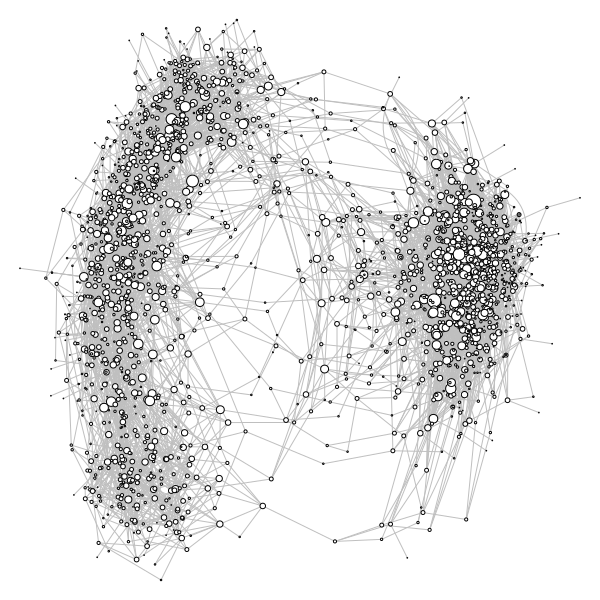

In [25]:
#random subset of knn graph for plotting
short_knn=ig.Graph.TupleList([tuple(x) for x in knnG.values[random.sample(list(np.arange(len(knnG.values))), 5000)]], directed=False)

#This plots each graph, using degree to present node size:
short_knn.vs['degree']=short_knn.degree() 
short_knn.vs['degree_size']=[(x*15)/(max(short_knn.vs['degree'])) for x in short_knn.vs['degree']] #degree is multiplied by 10 so that we can see all nodes

layout = short_knn.layout_mds()
ig.plot(short_knn, layout=layout, vertex_color='white', edge_color='silver', vertex_size=short_knn.vs['degree_size'])

In the next table, we can see that while the same number of nodes is found in all networks, the number of edges varies greatly. We also see that the network is fully connected, which is not allways the case. If it wasn't connected, we could select the ***k***  largest connected components, and proceed the analyses with them. The largest connected component is called the *giant component*.

In [30]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pos_w, all_u, knn, random_posw, random_allu, random_knn]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['pos_w','all_u','knn','pos_w_random', 'all_u_random', 'knn_random']
network_stats

node_count edge_count diameter av_path_length   density  \
pos_w              2102     293544        8       2.933039  0.132937   
all_u              2102     402360        7        2.11979  0.182216   
knn                2102     420400        4       2.320016  0.190386   
pos_w_random       2102     293544        2       1.867063  0.132937   
all_u_random       2102     402360        2       1.817784  0.182216   
knn_random         2102     420400        2       1.809614  0.190386   

             clustering_coef connected? minimum_cut  
pos_w                0.71453      False         0.0  
all_u               0.610098      False         0.0  
knn                 0.590294       True       203.0  
pos_w_random         0.13285       True       226.0  
all_u_random        0.182233       True       320.0  
knn_random           0.19034       True       338.0

### Questions:
- Why is the diameter and average path length lower in the case of the full network and the random network, compared to the other two networks? What about the other random networks?
- Why do you think the clustering coefficient is lower for the knn compared with the other networks?
- Why is the minimum cut much larger in the random network compared to the others?
- How do you think the selected *k* would influence the properties above for kNNG?

# Centrality analysis

We'll look into different centrality measures:
- [Degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)) - number of neighbors of a node
- [Betweenness](https://en.wikipedia.org/wiki/Betweenness_centrality) - measures how many shortest paths in the network pass through a node.
- [Closeness](https://en.wikipedia.org/wiki/Centrality#Closeness_centrality) - the average length of the shortest paths between a node and all other nodes 
- [Eccentricity](https://en.wikipedia.org/wiki/Distance_(graph_theory)) - largest shortest path from a node to any other node. Nodes with high eccentricity tend to be on the periphery.
- [Eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) - a node is more central if its neighbors show a high degree.

Degree, Betweenness, Closeness and Eigenvector centralities may be additionally computed for the positive association network by taking into account each edge's weight. For instance, for degree this is done for each node by summing each edge's degree.

Because the number of shortest paths in a network scales with the network size, we normalize Eccentricity and Betweenness with respect to the network size so that they can be compared between the four networks above.

Note that many [other centrality metrics](https://en.wikipedia.org/wiki/Centrality) can be computed. For instance, [PageRank](https://en.wikipedia.org/wiki/PageRank) and [HITS](https://en.wikipedia.org/wiki/HITS_algorithm) take into account edge directionality to compute what are the most central nodes in a network. 

**Degree distribution**  
Let's start by comparing the degrees of the random network against the three other networks. From the figures below it seems that there is no relationship between the degree of the random network, and any of the three others.

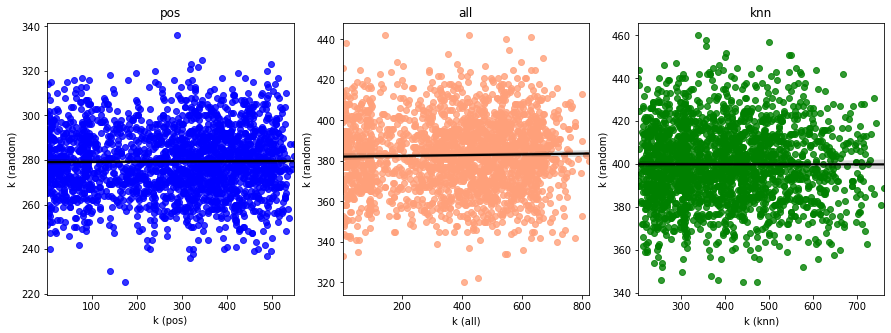

In [27]:
fig, axes=plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, ax in zip(range(4), axes.flat):
    sns.regplot(x=[pos_w,all_u,knn][i].degree(), y=[random_posw, random_allu, random_knn][i].degree(), 
                ax=ax, color=['blue','lightsalmon','green'][i],
               line_kws={'color':'black'}
               );
    ax.set_title(['pos','all','knn'][i])
    ax.set(xlabel='k ('+['pos','all','knn'][i]+')', ylabel='k (random)')

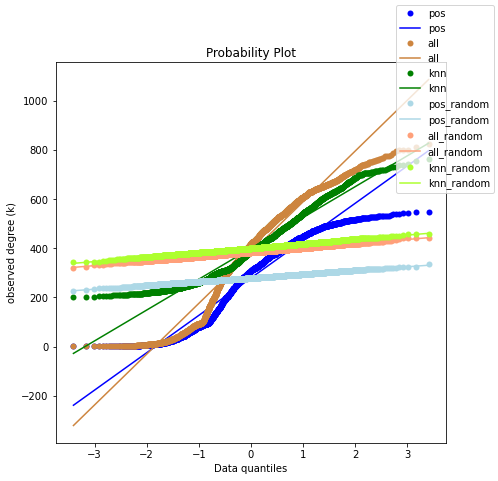

In [28]:
def transform_degree(graph):
    alldegs=graph.degree()
    alldegs=pd.DataFrame([[key,len(list(group))] for key,group in itertools.groupby(alldegs)], columns=['k','count'])
    alldegs['P(k)']=[x/alldegs['count'].sum() for x in alldegs['count']]
    alldegs=alldegs.loc[:,['k','P(k)']]
    alldegs.drop_duplicates(inplace=True)
    alldegs.reset_index(drop=True, inplace=True)
    return(alldegs)


fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale='log', xscale='log')
p=sp.stats.probplot(pos_w.degree(), plot=ax)
a=sp.stats.probplot(all_u.degree(), plot=ax)
k=sp.stats.probplot(knn.degree(), plot=ax)
r=sp.stats.probplot(random_posw.degree(), plot=ax)
r2=sp.stats.probplot(random_allu.degree(), plot=ax)
r3=sp.stats.probplot(random_knn.degree(), plot=ax)

col=['blue','','peru','','green','','lightblue','','lightsalmon','','greenyellow','']
for x in np.arange(0,11,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['pos','pos','all','all','knn','knn','pos_random','pos_random','all_random','all_random','knn_random','knn_random']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
plt.show()

**Centrality**  
We will now compare different centrality metrics between the graphs.

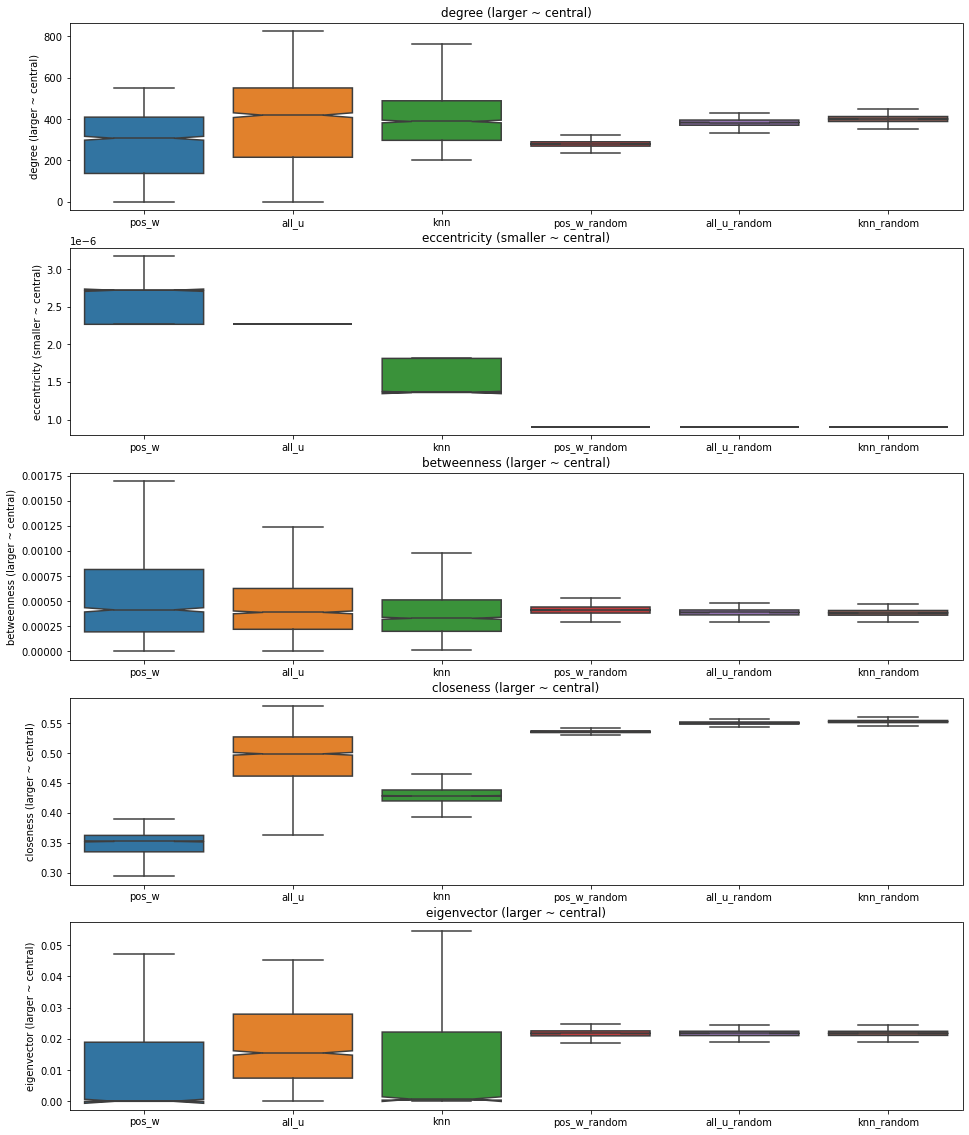

In [29]:
centralities_list=['degree (larger ~ central)','eccentricity (smaller ~ central)','betweenness (larger ~ central)', 'closeness (larger ~ central)','eigenvector (larger ~ central)']

def combine_raw_centralities():
    """
    Combines centrality metrics
    """
    def centrality_raw(input_graph, graph_name):
        """
        Computes centrality metrics for a graph.
        """
        deg=input_graph.degree(loops=False)
        node_n=input_graph.vcount()
        #scaled to account for network size
        ecc=[(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.eccentricity()]
        btw=[(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.betweenness(directed=False)] 
        eig=input_graph.eigenvector_centrality(directed=False, scale=False)
        
        # For disconnected graphs, computes closeness from the largest connected component
        if(input_graph.is_connected()):
            cls=input_graph.closeness(normalized=True)
        else:
            cls=input_graph.clusters(mode='WEAK').giant().closeness(normalized=True)
        
        out=pd.DataFrame([deg, ecc, btw, cls,eig], index=centralities_list).T
        out['graph']=graph_name
        out=out.loc[:,np.append(['graph'],out.columns[out.columns!='graph'])]
        
        ##Adds centralities for each node in the network
        input_graph.vs['degree']=out['degree (larger ~ central)']
        input_graph.vs['eccentricity']=out['eccentricity (smaller ~ central)']
        input_graph.vs['betweenness']=out['betweenness (larger ~ central)']
        input_graph.vs['closeness']=out['closeness (larger ~ central)']
        input_graph.vs['eigenvector']=out['eigenvector (larger ~ central)']
        
        return(out)
    
    #Computes centralities for all networks
    network_centralities_raw=pd.DataFrame()
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(pos_w,'pos_w')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(all_u,'all_u')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(knn,'knn')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(random_posw,'pos_w_random')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(random_allu,'all_u_random')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(random_knn,'knn_random')])
    return(network_centralities_raw)

network_centralities_raw=combine_raw_centralities()


fig, axes=plt.subplots(nrows=5, figsize=(16,20), sharey='row')
for i, ax in zip(range(6), axes.flat):
    sns.boxplot(
        data=network_centralities_raw, x='graph', y=centralities_list[i],  notch=True, ax=ax, showfliers=False)
    ax.set_title(centralities_list[i])
    ax.set(xlabel='')

When interpreting the results above, it is important to bear in mind that these networks have different network sizes. Recall:

In [30]:
network_stats

node_count edge_count diameter av_path_length   density  \
pos_w              2102     293544        8        2.93304  0.132937   
all_u              2102     402360        7        2.11979  0.182216   
knn                2102     420400        4        2.32002  0.190386   
pos_w_random       2102     293544        2        1.86706  0.132937   
all_u_random       2102     402360        2        1.81778  0.182216   
knn_random         2102     420400        2        1.80961  0.190386   

             clustering_coef connected? minimum_cut  
pos_w                0.71453      False           0  
all_u               0.610098      False           0  
knn                 0.590294       True         203  
pos_w_random        0.132907       True         225  
all_u_random        0.182253       True         320  
knn_random          0.190416       True         345

Overall, we see:
- The median degree centrality decreases from `Full network > kNNG >  Positive assoc. network`.
- The median betweenness centrality tends to decrease from `Positive assoc. network > Full network > kNNG`.
- The median closeness centrality  tends to decrease from `Full network > kNNG > Positive assoc. network`.
- The eccentricity is very homogeneous for the `Full network (all_u)`, and slightly lower than in the `Full network`. In turn, most nodes in the `kNNG` tend to display an eccentricity of 3-4.


### Questions:
- Can you explain these observations?
- Based on the plots above, which graphs do you think follow a [*small world*](https://en.wikipedia.org/wiki/Small-world_network) behavior?

We will also explore the relationships between different centrality metrics. Because these have different interpretations, we will compute ranks for each centrality, and perform the correlations on the ranks. In the following cell we do this, and then compute correlations within the 5 metrics for the full network. One additional column is presented (`median_centrality`), that is basically the median of the ranks of the 5 other centralities. 

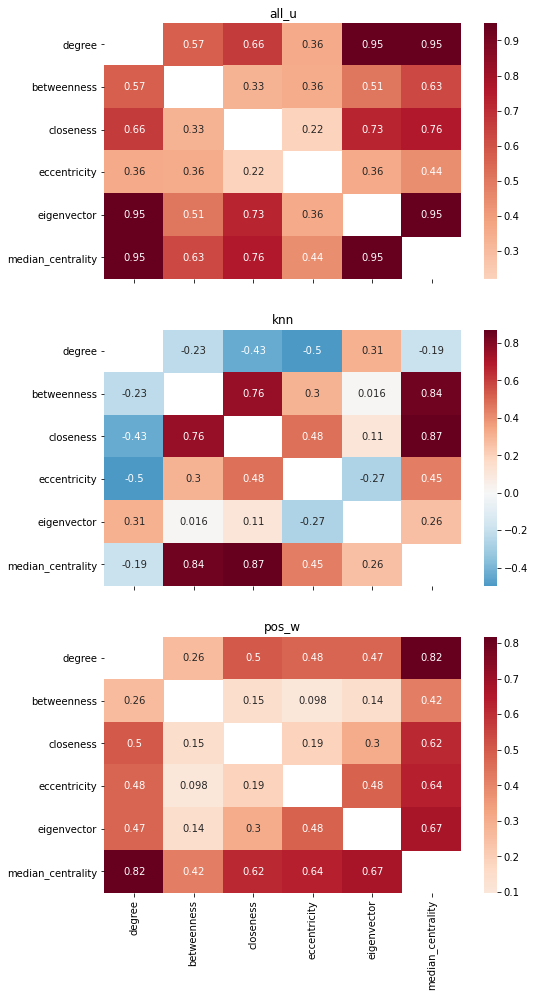

In [31]:
### Compute centrality ranks so that we can compare them within and between networks
full_centralities=pd.DataFrame()
for net in [0,1,2]:
    net_in=[pos_w, all_u, knn][net]
    net_nm=['pos_w', 'all_u', 'knn'][net]
    temp=pd.DataFrame([net_in.vs[att] for att in ['name','degree','betweenness', 'closeness','eccentricity','eigenvector']], index=['name','degree','betweenness', 'closeness','eccentricity','eigenvector']).T
    temp.columns=[x+'|'+net_nm for x in temp.columns]
    temp.rename(columns={'name|'+net_nm:'name'}, inplace=True)
    
    ## For all but eccentricity centrality, we compute the rank in ascending mode
    ## so that higher ranking means more central. we need to reverse this for eccentricity
    temp.loc[:,temp.columns.str.contains('deg|bet|clos|eig')]=temp.loc[:,temp.columns.str.contains('deg|bet|clos|eig')].rank(pct=True, ascending=True)
    temp.loc[:,temp.columns.str.contains('eccentricity')]=temp.loc[:,temp.columns.str.contains('eccentricity')].rank(pct=True, ascending=False
                                                              )
    temp['median_centrality|'+net_nm]=temp.loc[:,temp.columns!='name'].median(1)
    if(net==0):
        full_centralities=temp
    else:
        full_centralities=pd.merge(full_centralities, temp, on='name')
full_centralities.set_index('name', inplace=True)
full_centralities=pd.merge(full_centralities, data[['Type']], left_index=True, right_index=True, how='left')
full_centralities['median|ALL']=full_centralities.loc[:,full_centralities.columns.str.contains('median')].median(1)


### Correlations are computed between ranks, after inverting the rank for eccentricity
def correlations_centralities(graph_name):
    """
    Returns squared correlation matrix.
    """
    temp_corr=full_centralities.copy().loc[:,full_centralities.columns!='Type'].dropna().astype('float')
    temp_corr=temp_corr.loc[:,temp_corr.columns.str.contains(graph_name)]
    temp_corr.columns=temp_corr.columns.str.replace('\|.+','')
    temp_corr=temp_corr.corr(method='spearman')
    np.fill_diagonal(temp_corr.values, np.nan)
    return(temp_corr)

all_u_centcorr=correlations_centralities('all_u')
knn_centcorr=correlations_centralities('knn')
pos_w_centcorr=correlations_centralities('pos_w')

fig,ax=plt.subplots(nrows=3, figsize=(8,16), sharex=True)
ax=ax.flatten()
for i in range(3):
    tdata=[all_u_centcorr,knn_centcorr, pos_w_centcorr][i]
    tname=['all_u','knn','pos_w'][i]
    sns.heatmap(tdata, cmap="RdBu_r", center=0, annot=True, ax=ax[i]);
    ax[i].set(title=tname)

The plot above shows that most of the centrality metrics are positively correlated in the full network and in the positively coexpression network. However, this is not the case for the KNN network.

#### Questions

1. How do you explain the inverse relationship between degree and most other metrics in the KNN network?
2. Why do you think that the KNN network specifically displays this opposite trend?

The next figure may help in answering the question above. We highlight the most central nodes based on degree (red) and eccentricity (green), in addition to a random subset of 500 nodes. Of these, which do you think displays the shortest path to all other nodes?

In [32]:
knn_centralities=full_centralities.loc[:,full_centralities.columns.str.contains('knn')]
knn_centralities=knn_centralities.loc[:,knn_centralities.columns!='median_centrality|knn']
knn_centralities.columns=knn_centralities.columns.str.replace('\\|.+','')

##top nodes based on eccentricity
knn_top_ecc=knn_centralities['eccentricity'].sort_values(ascending=False).index.values[:1]

##top nodes based on degree
knn_top_deg=knn_centralities['degree'].sort_values(ascending=False).index.values[:1]

##random nodes to help visualize
##warning, do not increase this value much higher than 500, or you may have problems rendering this image
knn_others=knn_centralities.sample(500).index.values

## full list
node_list=np.append(np.append(knn_top_deg, knn_top_ecc), knn_others)

## subsets nodes
knn_to_draw=knn.subgraph(knn.vs.select([x.index for x in knn.vs if x['name'] in node_list]))
knn_to_draw.vs['color']=['red' if x['name']  in knn_top_deg else 'green' if x['name'] in knn_top_ecc else 'white' for x in knn_to_draw.vs]

layout = knn_to_draw.layout_auto()
ig.plot(knn_to_draw, layout=layout, vertex_color=knn_to_draw.vs['color'], edge_color='silver', vertex_size=7)

# Community analysis

Node communities may be identified based on different metrics including [Modularity](https://en.wikipedia.org/wiki/Modularity_(networks)) or [Density](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.016114). We will look at community detection through modularity.

## Modularity of a small graph

Recall that the Modularity of a community is given by $$Q = \frac{1}{2m} \sum_{c}(e_c - \frac{K_c^2}{2m})$$

where $e_c$ is the number of edges in community $c$, and $\frac{K_c^2}{2m}$ is the expected number of edges in the community given the $K_c$ sum of degrees of its nodes, for a network with $m$ edges. This will correspond to

$$Q = \frac{1}{2m} \sum_{ij}[A_{ij} - \frac{k_i k_j}{2m}\delta(c_i,c_j)]$$

where $A_ij$ is the Adjacency between nodes $i$ and $j$, $k_i$ and $k_j$ are their degree, and $\delta(c_i,c_j)$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta), defined as 1 if nodes $i$ and $j$ are in the same community, or 0 if they are not. Let's examine the following small network, with communities given by the two colors: red `[A,B,C,D,H]` and blue `[E,F,G]`.

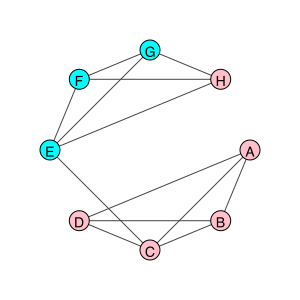

In [33]:
g = ig.Graph([(0,1), (0,2), (1,2), (0,3), (2,3), (1,3), (2,4), (4,5), (5,6), (4,6), (4,7), (5,7), (6,7)])

g.vs["name"] = ["A", "B", "C", "D", "E", "F", "G","H"]
g.vs["module"] = ["f", "f", "f", "f", "m", "m","m", "f"]


layout = g.layout_circle()
g.vs["label"] = g.vs["name"]
color_dict = {"m": "cyan", "f": "pink"}
g.vs["color"] = [color_dict[module] for module in g.vs["module"]]
ig.plot(g, layout = layout, bbox = (300, 300), margin = 50)

For this network, we have the following adjacency matrix.

In [34]:
pd.DataFrame( g.get_adjacency(), index=g.vs["name"],  columns=g.vs["name"] )

A  B  C  D  E  F  G  H
A  0  1  1  1  0  0  0  0
B  1  0  1  1  0  0  0  0
C  1  1  0  1  1  0  0  0
D  1  1  1  0  0  0  0  0
E  0  0  1  0  0  1  1  1
F  0  0  0  0  1  0  1  1
G  0  0  0  0  1  1  0  1
H  0  0  0  0  1  1  1  0

We will compute the modularity of this network given the 2 communities above, herein identified as communities `1` and `2`.

In [35]:
def modularity(graph, membership):
    """
    Computes the modularity of `graph` for a given module `membership`.
    """
    m=len(graph.es.indices) #edge number
    A=pd.DataFrame(graph.get_adjacency()) #adjacency matrix
    Q=[] 
    for i in A.index:
        for j in A.columns:
            if(membership[i]==membership[j]):
                deltaij=1
            else:
                deltaij=0
            Q=np.append(Q, (A.loc[i,j]-(g.vs[i].degree()*g.vs[j].degree())/(2*m))*deltaij)
    Q=(1/(2*m))*np.sum(Q)
    out=Q
    return(out)

modularity(g, [1,1,1,1,2,2,2,1])

0.16568047337278102

As this is a very small network, we can take a brute-force approach and examine all possible membership combinations that will yield the highest possible modularity.

In [36]:
all_memberships=[x for x in itertools.product([1,2], repeat=8)]


membership_modularity=pd.DataFrame()
for membership in all_memberships:
    group1=[g.vs['name'][x] for x in range(len(g.vs['name'])) if membership[x]==1]
    group2=[g.vs['name'][x] for x in range(len(g.vs['name'])) if membership[x]==2]
    out=pd.Series([group1, group2, membership, modularity(g, membership)], index=['comm1', 'comm2','memb','Q'])
    membership_modularity=pd.concat([membership_modularity, out], 1)
    
membership_modularity=membership_modularity.T.sort_values('Q', ascending=False)
membership_modularity.head(10)

comm1            comm2                      memb         Q
0     [A, B, C, D]     [E, F, G, H]  (1, 1, 1, 1, 2, 2, 2, 2)  0.423077
0     [E, F, G, H]     [A, B, C, D]  (2, 2, 2, 2, 1, 1, 1, 1)  0.423077
0  [A, B, C, D, E]        [F, G, H]  (1, 1, 1, 1, 1, 2, 2, 2)  0.221893
0        [A, B, D]  [C, E, F, G, H]  (1, 1, 2, 1, 2, 2, 2, 2)  0.221893
0        [F, G, H]  [A, B, C, D, E]  (2, 2, 2, 2, 2, 1, 1, 1)  0.221893
0  [C, E, F, G, H]        [A, B, D]  (2, 2, 1, 2, 1, 1, 1, 1)  0.221893
0  [A, B, C, D, H]        [E, F, G]  (1, 1, 1, 1, 2, 2, 2, 1)   0.16568
0        [B, C, D]  [A, E, F, G, H]  (2, 1, 1, 1, 2, 2, 2, 2)   0.16568
0  [D, E, F, G, H]        [A, B, C]  (2, 2, 2, 1, 1, 1, 1, 1)   0.16568
0  [A, E, F, G, H]        [B, C, D]  (1, 2, 2, 2, 1, 1, 1, 1)   0.16568

We can see that the 2 top hits that maximize modularity define the same communities as `[A,B,C,D]` and `[E,F,G,H]`. For larger networks we cannot use a brute-force approach, and instead rely on the 2-pass Louvain algorithm, which has since been improved with the Leiden algorithm.

## Modularity of gene-metabolite networks

Below, we perform the community analysis on the 4 networks. We will perform one additional community analysis by considering the edge weights from the positively associated network. Importantly, this method searches for the largest possible communities for our network, which may not always be the desired. Alternative models such as the [Constant Potts Model](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.016114) allow you to identify smaller communities. Should we know that our data has special feature classes, we can compare whether the communities identify those classes by examining them individually, and increasing the resolution if needed.

In [37]:
pos_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition)
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition, weights='w')
all_comm = leidenalg.find_partition(all_u, leidenalg.ModularityVertexPartition)
knn_comm = leidenalg.find_partition(knn, leidenalg.ModularityVertexPartition)
random_all = leidenalg.find_partition(random_allu, leidenalg.ModularityVertexPartition)
random_posw = leidenalg.find_partition(random_posw, leidenalg.ModularityVertexPartition)
random_knn = leidenalg.find_partition(random_knn, leidenalg.ModularityVertexPartition)

Predictably, we can see that the modularity score of any of the networks is substantially larger than that of the random network.

In [38]:
np.round(pos_comm.modularity,3)

0.591

In [39]:
np.round(pos_w_comm.modularity,3)

0.591

In [40]:
np.round(all_comm.modularity,3)

0.427

In [41]:
np.round(knn_comm.modularity,3)

0.591

In [42]:
np.round(random_all.modularity,3)

0.039

In [43]:
np.round(random_posw.modularity,3)

0.046

In [44]:
np.round(random_knn.modularity,3)

0.038

Comparing the different communities by size:

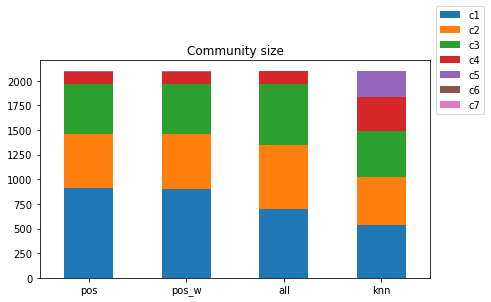

In [45]:
#Compiles feat lists per community
def get_community_table():
    comm_counts=pd.DataFrame()
    feat_lists=pd.DataFrame()
    for i in [0,1,2,3]:
        graph=[pos_w,pos_w,all_u,knn][i]
        comm=[pos_comm,pos_w_comm,all_comm,knn_comm][i]
        name=['pos','pos_w','all','knn'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'feat',1:'community'})
        counts=pd.DataFrame(temp.groupby('community')['feat'].agg(len))
        counts.columns=[name]
        comm_counts=pd.concat([comm_counts, counts],1)
        
        gl=pd.DataFrame(temp.groupby('community')['feat'].apply(list)).reset_index()
        gl['community']=['c'+str(i) for i in gl['community']]
        gl['network']=name
        gl=gl.loc[:,['network','community','feat']]
        feat_lists=pd.concat([feat_lists, gl])
        
    comm_counts.index=['c'+str(i) for i in comm_counts.index]
    return([comm_counts,feat_lists])

#Plotting community sizes
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 4))
bar_data=get_community_table()[0].fillna(0).T
bar_data.plot(kind='bar', stacked=True, ax=ax);
# ## number of communities in each
# for index, row in groupedvalues.iterrows():
#     g.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")
ax.legend(get_community_table()[0].index, loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

Some of the communities are very small in the `pos` and full networks, and comprise only 2 and 3 elements. Can we really call this a community?

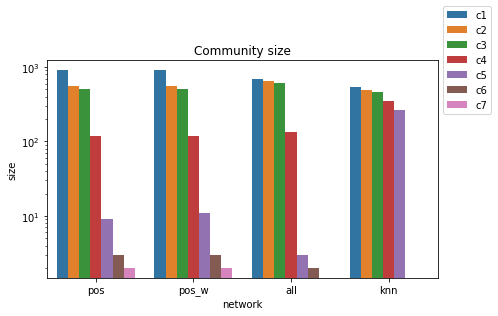

In [46]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=bar_data.T.unstack().reset_index().rename(columns={'level_0':'network','level_1':'community',0:'size'}),
    x='network',y='size', hue='community'
           )

ax.set(yscale='log');
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

**Functional analysis**  
In order to perform functional enrichment, we will extract each of the communities and perform a hypergeometric test **on the genes** to understand whether they are particularly enriched in specific biological functions.  
We will use [enrichr](https://gseapy.readthedocs.io/en/master/gseapy_example.html#2.-Enrichr-Example) to perform the gene set enrichment analysis. As background we will use the full list of genes that were quantified.

We will look at 3 gene set libraries. Should you have other kinds of data, enrichr allows you to define your own feature sets and perform a similar analysis. The challenge is in identifying comprehensive and well curated gene sets.

In [47]:
#All the available human libraries
gp.get_library_name(database='Human')[:15]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016']

In [48]:
#we will search 3 libraries for significantly enriched gene sets
gene_sets=['GO_Biological_Process_2018','KEGG_2019_Human','OMIM_Disease']
background=[x for x in all_u.copy().vs['name'] if x in data.loc[data.Type=='genes'].index]
all_genes=data.loc[data.Type=='genes'].index

def perform_enrich(network):
    temp=get_community_table()[1].copy()
    temp=temp.loc[temp['network']==network]
    output_enrichr=pd.DataFrame()
    for comm in temp['community'].values:
        gl=list(temp.loc[temp['community']==comm, 'feat'])[0]
        gl=list([x for x in gl if x in all_genes])
        
        if(len(gl)<30):
            continue
        print('Found '+str(len(gl))+' genes in community '+comm)
        for bp in gene_sets:
            print('Analyzing '+network+' network | Comm: '+comm+'/'+str(len(temp.index))+'  | BP: '+bp)
            enr=gp.enrichr(
                gene_list=gl,
                gene_sets=bp,
                background=background,
                outdir='Enrichr',
                format='png'
            )

            results=enr.results.sort_values('Adjusted P-value', ascending=True)
            results=results.loc[results['Adjusted P-value']<0.05,]
            results['BP']=bp
            results['Comm']=comm
            results['Graph']=network
            output_enrichr=pd.concat([output_enrichr, results])
            
    return(output_enrichr)

all_enriched=pd.DataFrame()
for net in ['pos', 'pos_w', 'all', 'knn']: 
    all_enriched=pd.concat([all_enriched,perform_enrich(net)])

Found 904 genes in community c1
Analyzing pos network | Comm: c1/7  | BP: GO_Biological_Process_2018


2021-07-10 23:31:59,120 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing pos network | Comm: c1/7  | BP: KEGG_2019_Human


2021-07-10 23:32:03,362 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing pos network | Comm: c1/7  | BP: OMIM_Disease


2021-07-10 23:32:07,463 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 555 genes in community c2
Analyzing pos network | Comm: c2/7  | BP: GO_Biological_Process_2018
Analyzing pos network | Comm: c2/7  | BP: KEGG_2019_Human
Analyzing pos network | Comm: c2/7  | BP: OMIM_Disease
Found 505 genes in community c3
Analyzing pos network | Comm: c3/7  | BP: GO_Biological_Process_2018
Analyzing pos network | Comm: c3/7  | BP: KEGG_2019_Human
Analyzing pos network | Comm: c3/7  | BP: OMIM_Disease


2021-07-10 23:32:33,172 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 902 genes in community c1
Analyzing pos_w network | Comm: c1/7  | BP: GO_Biological_Process_2018


2021-07-10 23:32:37,832 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing pos_w network | Comm: c1/7  | BP: KEGG_2019_Human


2021-07-10 23:32:42,034 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing pos_w network | Comm: c1/7  | BP: OMIM_Disease


2021-07-10 23:32:46,118 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 556 genes in community c2
Analyzing pos_w network | Comm: c2/7  | BP: GO_Biological_Process_2018
Analyzing pos_w network | Comm: c2/7  | BP: KEGG_2019_Human
Analyzing pos_w network | Comm: c2/7  | BP: OMIM_Disease
Found 508 genes in community c3
Analyzing pos_w network | Comm: c3/7  | BP: GO_Biological_Process_2018
Analyzing pos_w network | Comm: c3/7  | BP: KEGG_2019_Human
Analyzing pos_w network | Comm: c3/7  | BP: OMIM_Disease


2021-07-10 23:33:12,214 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 692 genes in community c1
Analyzing all network | Comm: c1/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c1/6  | BP: KEGG_2019_Human
Analyzing all network | Comm: c1/6  | BP: OMIM_Disease


2021-07-10 23:33:25,899 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 652 genes in community c2
Analyzing all network | Comm: c2/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c2/6  | BP: KEGG_2019_Human
Analyzing all network | Comm: c2/6  | BP: OMIM_Disease
Found 614 genes in community c3
Analyzing all network | Comm: c3/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c3/6  | BP: KEGG_2019_Human
Analyzing all network | Comm: c3/6  | BP: OMIM_Disease


2021-07-10 23:33:52,914 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 433 genes in community c1
Analyzing knn network | Comm: c1/5  | BP: GO_Biological_Process_2018


2021-07-10 23:33:57,269 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing knn network | Comm: c1/5  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c1/5  | BP: OMIM_Disease


2021-07-10 23:34:05,011 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 484 genes in community c2
Analyzing knn network | Comm: c2/5  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c2/5  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c2/5  | BP: OMIM_Disease
Found 460 genes in community c3
Analyzing knn network | Comm: c3/5  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c3/5  | BP: KEGG_2019_Human


2021-07-10 23:34:27,512 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing knn network | Comm: c3/5  | BP: OMIM_Disease


2021-07-10 23:34:30,978 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 343 genes in community c4
Analyzing knn network | Comm: c4/5  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c4/5  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c4/5  | BP: OMIM_Disease
Found 263 genes in community c5
Analyzing knn network | Comm: c5/5  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c5/5  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c5/5  | BP: OMIM_Disease


From the output of the cell above you can readily see that some communities such as `c1` display no enriched terms from either [GO](http://geneontology.org/), [KEGG](https://www.genome.jp/kegg/) or [OMIM](https://www.omim.org/).

Running the command above not only gives you the results after significance testing (Q<0.05), but it also outputs some preliminary barplots with the statistically significant results (found under `/Enrichr/`). For instance:
<img src="./Enrichr/GO_Biological_Process_2018.human.enrichr.reports.png">

In [49]:
enriched_terms=all_enriched.loc[:,['Graph','Comm','Term','Adjusted P-value']].copy()

In [50]:
enriched_terms['Adjusted P-value']=-1*np.log10(enriched_terms['Adjusted P-value'])

In [51]:
enriched_terms.head()

Graph Comm                                               Term  \
0   pos   c2  cotranslational protein targeting to membrane ...   
1   pos   c2               protein targeting to ER (GO:0045047)   
2   pos   c2  SRP-dependent cotranslational protein targetin...   
3   pos   c2  nuclear-transcribed mRNA catabolic process, no...   
4   pos   c2                 viral gene expression (GO:0019080)   

   Adjusted P-value  
0         74.090213  
1         72.662625  
2         72.662625  
3         63.400913  
4         60.805013

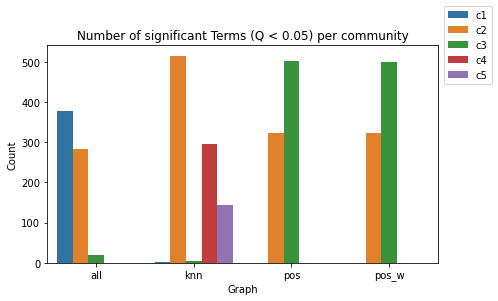

In [52]:
fig, ax = plt.subplots(figsize=(7, 4))
data_bars=pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count')).stack().reset_index().rename(columns={0:'Count'})
sns.barplot(x='Graph', y='Count', data=data_bars, hue='Comm')
ax.set_title('Number of significant Terms (Q < 0.05) per community')
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
plt.xticks(rotation=0)
plt.show()

Note that some of these communities are very big, which explains the big number of biological processes found above.

In [53]:
###Number of genes/community
# We skipped communities with <30 genes
get_community_table()[0].fillna(0).T

c1     c2     c3     c4     c5   c6   c7
pos    907.0  555.0  507.0  119.0    9.0  3.0  2.0
pos_w  902.0  556.0  510.0  118.0   11.0  3.0  2.0
all    694.0  656.0  614.0  133.0    3.0  2.0  0.0
knn    539.0  487.0  462.0  347.0  267.0  0.0  0.0

In [54]:
pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count'))

Term
Graph Comm      
all   c1     378
      c2     284
      c3      19
knn   c1       1
      c2     515
      c3       5
      c4     295
      c5     143
pos   c2     323
      c3     501
pos_w c2     323
      c3     500

We can now find whether the Full Network, Positively associated, and Positively associated weighted, show any common terms among their biggest communities. We do not compare with kNN-G as this shows very homogeneous and different communities than the other two networks

In [55]:
#Finding consensus
temp=enriched_terms.copy()
temp['comm_term']=temp.Comm+'_'+temp.Term
temp=temp.loc[:,['Graph','comm_term']]

consensus=pd.DataFrame()
consensus=pd.concat([consensus, temp.loc[temp['Graph']=='pos']])
consensus=pd.merge(consensus,
                   temp.loc[temp['Graph']=='pos_w'], on="comm_term", how='outer', suffixes=['pos','pos_w'])
consensus=pd.merge(consensus, 
                   temp.loc[temp['Graph']=='all'], on="comm_term", how='outer').rename(columns={'Graph':'all'})

consensus=consensus.loc[consensus.isna().sum(1)==0].loc[:,['comm_term','Graphpos','Graphpos_w','all']]

Among the biggest communities we find several biological processes (55) that are simultaneously identified in the same community in the three graphs (`Full`, `Pos assoc`, and `Pos assoc weighted`).

In [56]:
consensus['comm']=[x[0] for x in consensus.comm_term.str.split('\_')]
consensus.groupby('comm')['comm_term'].agg('count')

comm
c2    238
c3     16
Name: comm_term, dtype: int64

**Questions**  
- Would you exclude any communities based on its size?
- Having identified these communities, how would you try to validate them?
- Would you now determine the relevant community to investigate further?


If you want to export communities to use them in other sections.

In [57]:
#Requires running the community detection from the previous section
patlas=pd.read_csv('data/proteinatlas.tsv', sep="\t").loc[:,['Ensembl','Gene']]

In [58]:
#Compiles gene lists per community. We need Ensembl ids for further analyses
def get_ensembl():
    comm_counts=pd.DataFrame()
    gene_lists=pd.DataFrame()
    for i in [0,1,2,3]:
        graph=[pos_w,pos_w,all_u,knn][i]
        comm=[pos_comm,pos_w_comm,all_comm,knn_comm][i]
        name=['pos','pos_w','all','knn'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'gene',1:'community'})

        gl=pd.DataFrame(temp.groupby('community')['gene'].apply(list)).reset_index()
        gl['community']=['c'+str(i) for i in gl['community']]
        gl['network']=name
        gl=gl.loc[:,['network','community','gene']]
        gene_lists=pd.concat([gene_lists, gl])

    gene_communities=gene_lists
    gene_mat=pd.DataFrame()
    for net in gene_communities['network'].unique():
        temp=gene_communities.copy().loc[gene_communities['network']==net,]
        for comm in temp['community'].unique():
            gl=list(temp.copy().loc[temp['community']==comm,'gene'])[0]
            el=[patlas.loc[patlas['Gene']==x,'Ensembl'].iloc[0] for x in gl if x in patlas['Gene'].values]

            df=pd.DataFrame([net,comm,gl,el]).T
            df.columns=['network','community','Gene','Ensembl']
            gene_mat=pd.concat([gene_mat, df])
                
    return(gene_mat)

get_ensembl().to_csv('data/gene_communities.tsv', sep="\t", index=False)

# Conclusion

Here we've performed some network analyses based on a met-gene association network. We've explored different centrality measures to characterize the networks, and identified the communities of genes in these networks. We have also used gene set enrichment analysis to characterize these communities based on the genes, but it remains to show whether similar results would be attained if we considered the metabolites in each community.  